In [1]:
import pandas as pd
import os

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

import math
import time



def extract_sampling_point_id(samplingpoint):
    return samplingpoint.str.replace('CZ/', '', regex=False)

def load_data():
    data_folder = 'data'
    dfs = []

    for file_name in os.listdir(data_folder):
        if file_name.endswith(".parquet"):
            file_path = os.path.join(data_folder, file_name)
            df = pd.read_parquet(file_path)
            dfs.append(df)

    df = pd.concat(dfs, ignore_index=True)
    additional_data = pd.read_csv('data\DataExtract.csv')   
    df['Sampling Point Id'] = extract_sampling_point_id(df['Samplingpoint'])
    # Merge the 'B-G Namespace' column from additional_data into df based on the 'Sampling Point Id' column
    df = pd.merge(df, additional_data[['Sampling Point Id', 'Air Quality Station Name', 'Air Pollutant', 'Longitude','Latitude',
        'Altitude', 'Altitude Unit', 'Air Quality Station Area','Measurement Method']], on='Sampling Point Id', how='left')
    df['City Name'] = df['Air Quality Station Name'].str.split('-').str[0]
    df = df.drop("Sampling Point Id", axis=1)
    df['Date'] = pd.to_datetime(df['Start'])
    df = df[['Value','Air Pollutant','Date','City Name']]
    df = df[df['Value']>=0]
    df = df.dropna()
    return df

df = load_data()

In [7]:
pollutants = ['NO2', 'PM10', 'O3', 'PM2.5', 'SO2']
# Create separate DataFrames for each pollutant


# Now, you have separate DataFrames for each pollutant, with all other columns retained

Cities = ['Praha', 'Brno', 'Kucharovice', 'Mikulov',
       'Znojmo', 'Ceske Budejovice', 'Churanov', 'Hojna Voda',
       'Kocelovice', 'Prachatice', 'Tabor', 'Moravska Trebova ',
       'Pardubice', 'Pardubice Dukla', 'Svratouch', 'Hradec Kralove',
       'Krkonose', 'Polom', 'Trutnov ', 'Kostelni Myslova', 'Kosetice',
       'Trebic', 'Cheb', 'Prebuz', 'Sokolov', 'Ceska Lipa', 'Frydlant',
       'Horni Vitkov', 'Liberec', 'Sous', 'Uhelna', 'Jesenik', 'Olomouc',
       'Prerov', 'Prostejov', 'Kamenny Ujezd', 'Plzen', 'Primda',
       'Beroun', 'Kladno', 'Mlada Boleslav', 'Ondrejov', 'Rozdalovice',
       'Bily Kriz', 'Cervena hora', 'Cesky Tesin', 'Frydek', 'Havirov',
       'Ostrava', 'Opava', 'Studenka', 'Trinec', 'Vernovice', 'Chomutov',
       'Decin', 'Doksany', 'Krupka', 'Lom', 'Litomerice', 'Medenec',
       'Most', 'Rudolice v Horach', 'Sneznik', 'Teplice', 'Tusimice',
       'Usti n.L.', 'Stitna n.Vlari', 'Tesnovice', 'Uherske Hradiste',
       'Valasske Mezirici', 'Zlin']

selected_city = 'Praha'
selected_pollutant = 'O3'
filtered_data = df[df['City Name'].str.contains(selected_city, case=False) & df['Air Pollutant'].str.contains(selected_pollutant, case=False)]
filtered_data = filtered_data.reset_index(drop=True)

In [8]:
value_column = filtered_data['Value']
# Convert the 'Value' column to float
value_column = value_column.astype(float)
# Calculate the quartiles
Q1 = value_column.quantile(0.01)
Q3 = value_column.quantile(0.99)
IQR = Q3 - Q1
# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Identify outliers
outliers = filtered_data[(filtered_data['Value'] < lower_bound) | (filtered_data['Value'] > upper_bound)]
filtered_data = filtered_data[~filtered_data.index.isin(outliers.index)]
filtered_data = filtered_data[['Date','Value']]
filtered_data = filtered_data.set_index(pd.to_datetime(filtered_data['Date'], format='%Y-%m-%d %H:%M:%S'), drop=True)
filtered_data = filtered_data.drop('Date', axis=1)
filtered_data = filtered_data.resample('D').mean()

<Axes: xlabel='Date'>

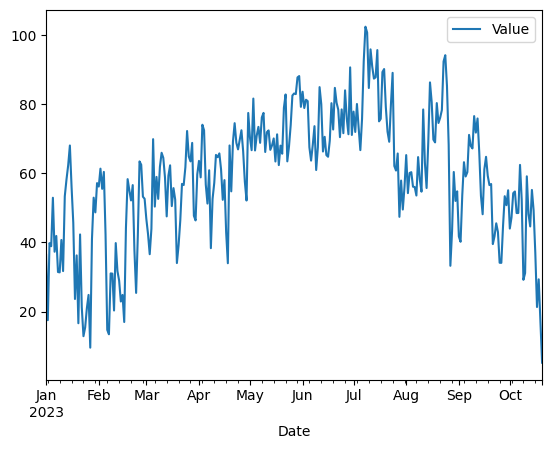

In [9]:
filtered_data.plot()

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(filtered_data['Value'], model='multiplicative')

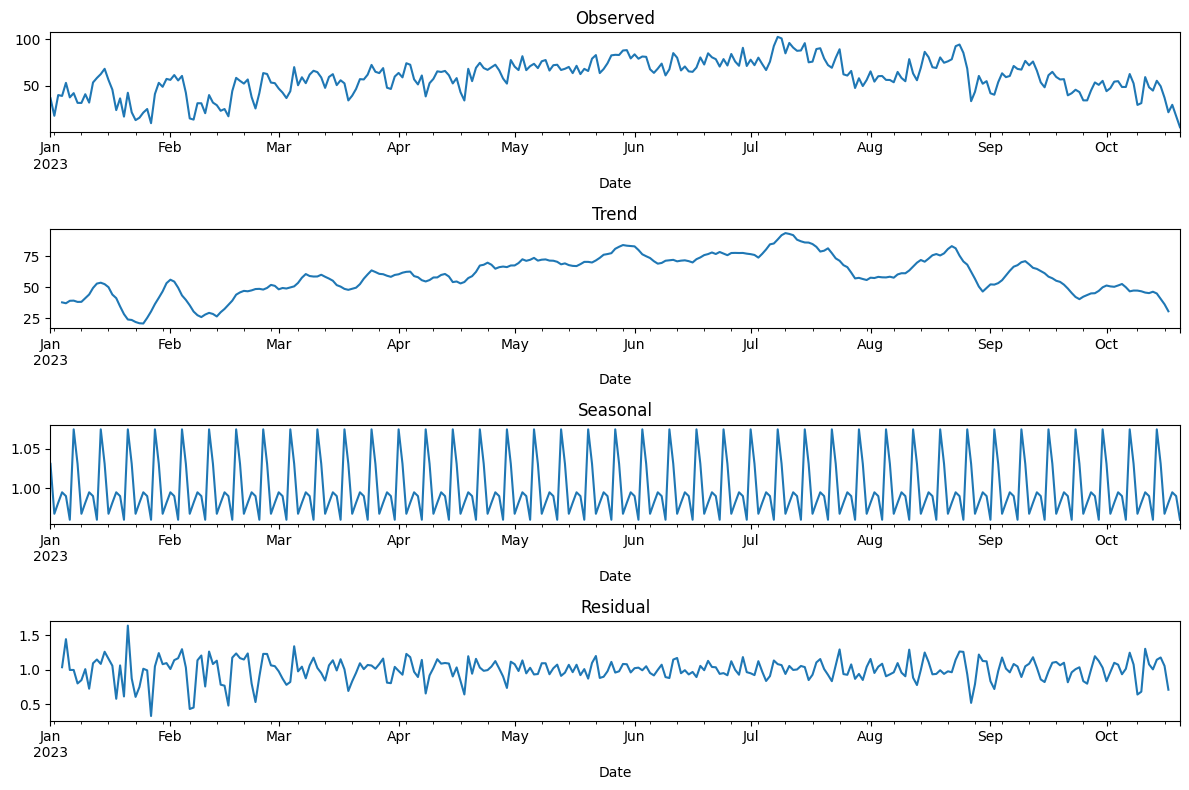

In [16]:
fig, axes = plt.subplots(4, figsize=(12, 8))
result.observed.plot(ax=axes[0], title='Observed')
result.trend.plot(ax=axes[1], title='Trend')
result.seasonal.plot(ax=axes[2], title='Seasonal')
result.resid.plot(ax=axes[3], title='Residual')
plt.tight_layout()
plt.show()

In [17]:
filtered_data['weekly_avg']= filtered_data['Value'].rolling(window=7).mean()
filtered_data['3_day_avg']= filtered_data['Value'].rolling(window=3).mean()
filtered_data['2_week_avg']= filtered_data['Value'].rolling(window=14).mean()

<Axes: xlabel='Date'>

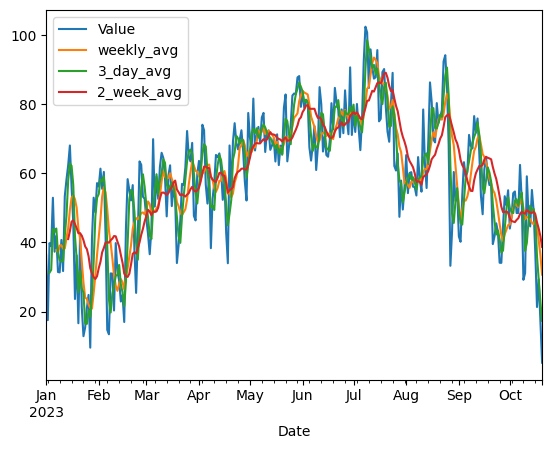

In [18]:
filtered_data.plot()